In [20]:
import cv2
import numpy as np

import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from patchify import patchify, unpatchify
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.utils import get_custom_objects
from patchify import patchify, unpatchify
import numpy as np
import math
import matplotlib.pyplot as plt

In [21]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
# Load the model you trained in task5_training.ipynb
patch_size = 256
example_file_name = 'Monika_Stangenberg_231648_unet_model_256px.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256, 256, 200)     400       
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      57632     
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      1

In [24]:
def trim_picture(picture):
    if len(picture.shape) == 2:
        picture = np.expand_dims(picture, axis=-1)

    picture = picture[:, :-150, :]
    xo, yo, zo = picture.shape
    x1 = xo // 2
    valid_columns = (picture[x1, :, :] >= 100).any(axis=1)
    trimmed_picture1 = picture[:, valid_columns, :]  
    x_trimmed, y_trimmed, z_trimmed = trimmed_picture1.shape

    y2 = y_trimmed // 2
    valid_rows = (trimmed_picture1[:, y2, :] >= 100).any(axis=1)
    trimmed_picture2 = trimmed_picture1[valid_rows, :, :]

    x, y, z = trimmed_picture2.shape

    if x == y:
        return trimmed_picture2.squeeze() 
    min_dim = min(x, y)
    if x > y:  
        excess = x - min_dim
        start = excess // 2
        end = start + min_dim
        squared_picture = trimmed_picture2[start:end, :, :]
    else: 
        excess = y - min_dim
        start = excess // 2
        end = start + min_dim
        squared_picture = trimmed_picture2[:, start:end, :]
    return squared_picture.squeeze() 

In [35]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image1 = cv2.imread(task5_test_image_path, 0)
original_shape = image.shape
print(original_shape)

(2684, 2684)


In [36]:
image = trim_picture(image1)

In [27]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image, (top_padding, bottom_padding, left_padding, right_padding)

In [28]:
petri_dish_padded, padding_info = padder(image, patch_size)

4/4 [==============================] - 13s 3s/step


Text(0.5, 1.0, 'Prediction')

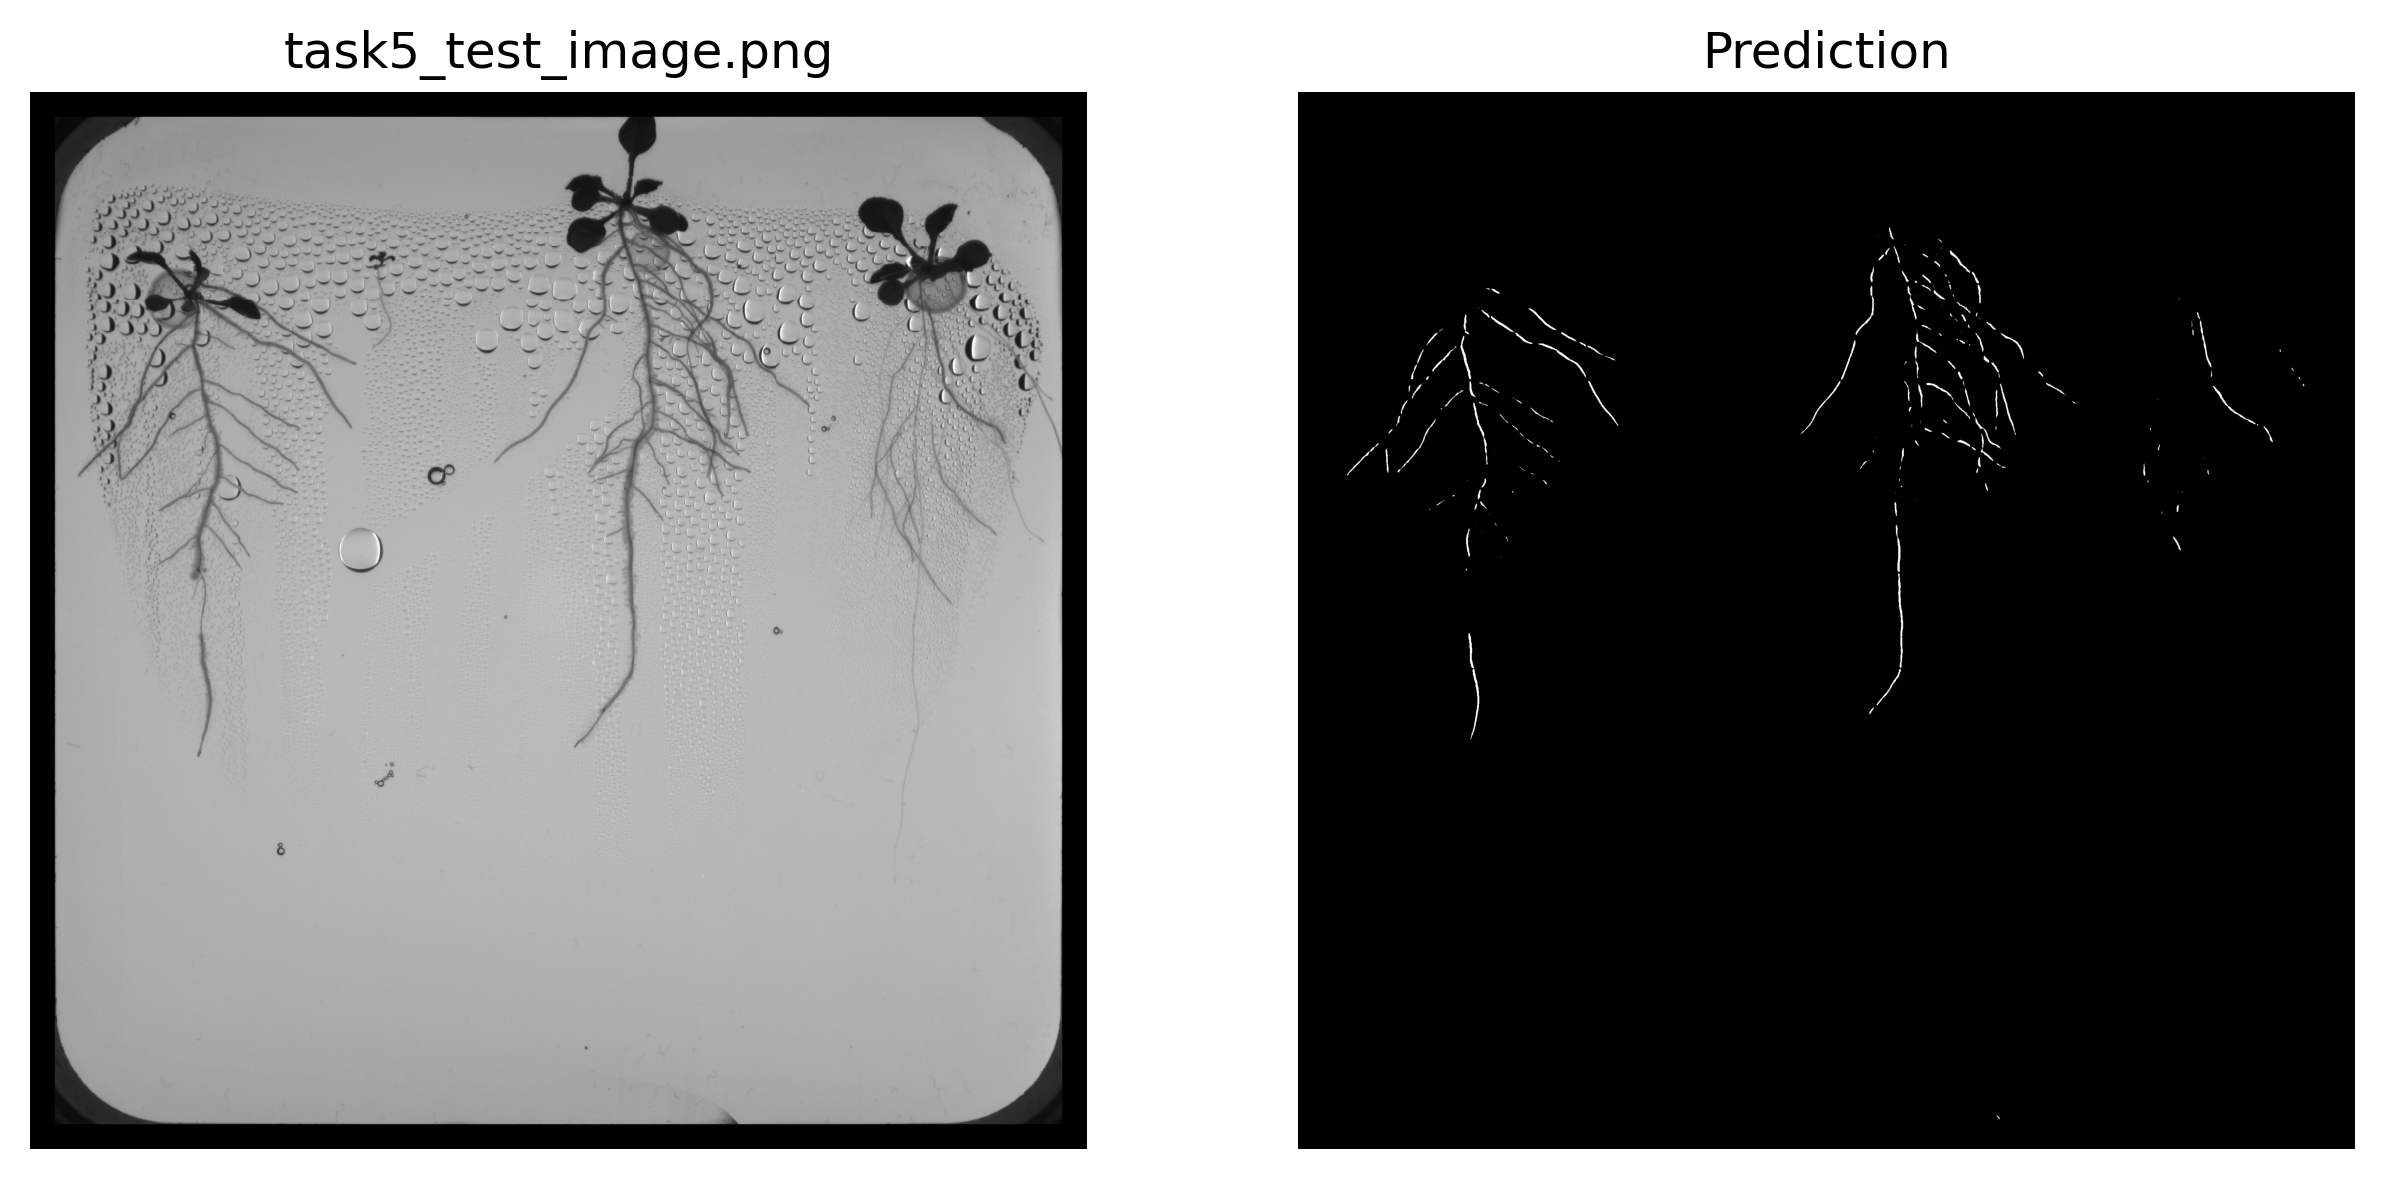

In [29]:
#petri_dish_padded1_gray = cv2.cvtColor(petri_dish_padded, cv2.COLOR_BGR2GRAY)


patch_size = 256
patches = patchify(petri_dish_padded, (patch_size, patch_size), step=patch_size)
patches_reshaped = patches.reshape(-1, patch_size, patch_size, 1) / 255.0  

# PREDICT
predicted_patches = model.predict(patches_reshaped)

# UNPATCH
num_patches_in_row = int(math.sqrt(predicted_patches.shape[0]))
predicted_patches_reshaped = predicted_patches.reshape(
    num_patches_in_row, num_patches_in_row, patch_size, patch_size
)
predicted_mask = unpatchify(predicted_patches_reshaped, petri_dish_padded.shape)

predicted_mask = (predicted_mask * 255).astype(np.uint8)

predicted_mask[predicted_mask >= 128] = 255
predicted_mask[predicted_mask < 128] = 0

# VISUALIZE
f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray', vmin=0, vmax=255)
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray', vmin=0, vmax=255)
ax[1].axis('off')
ax[1].set_title('Prediction')


In [30]:
predicted_mask.shape, petri_dish_padded.shape

((2816, 2816), (2816, 2816))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

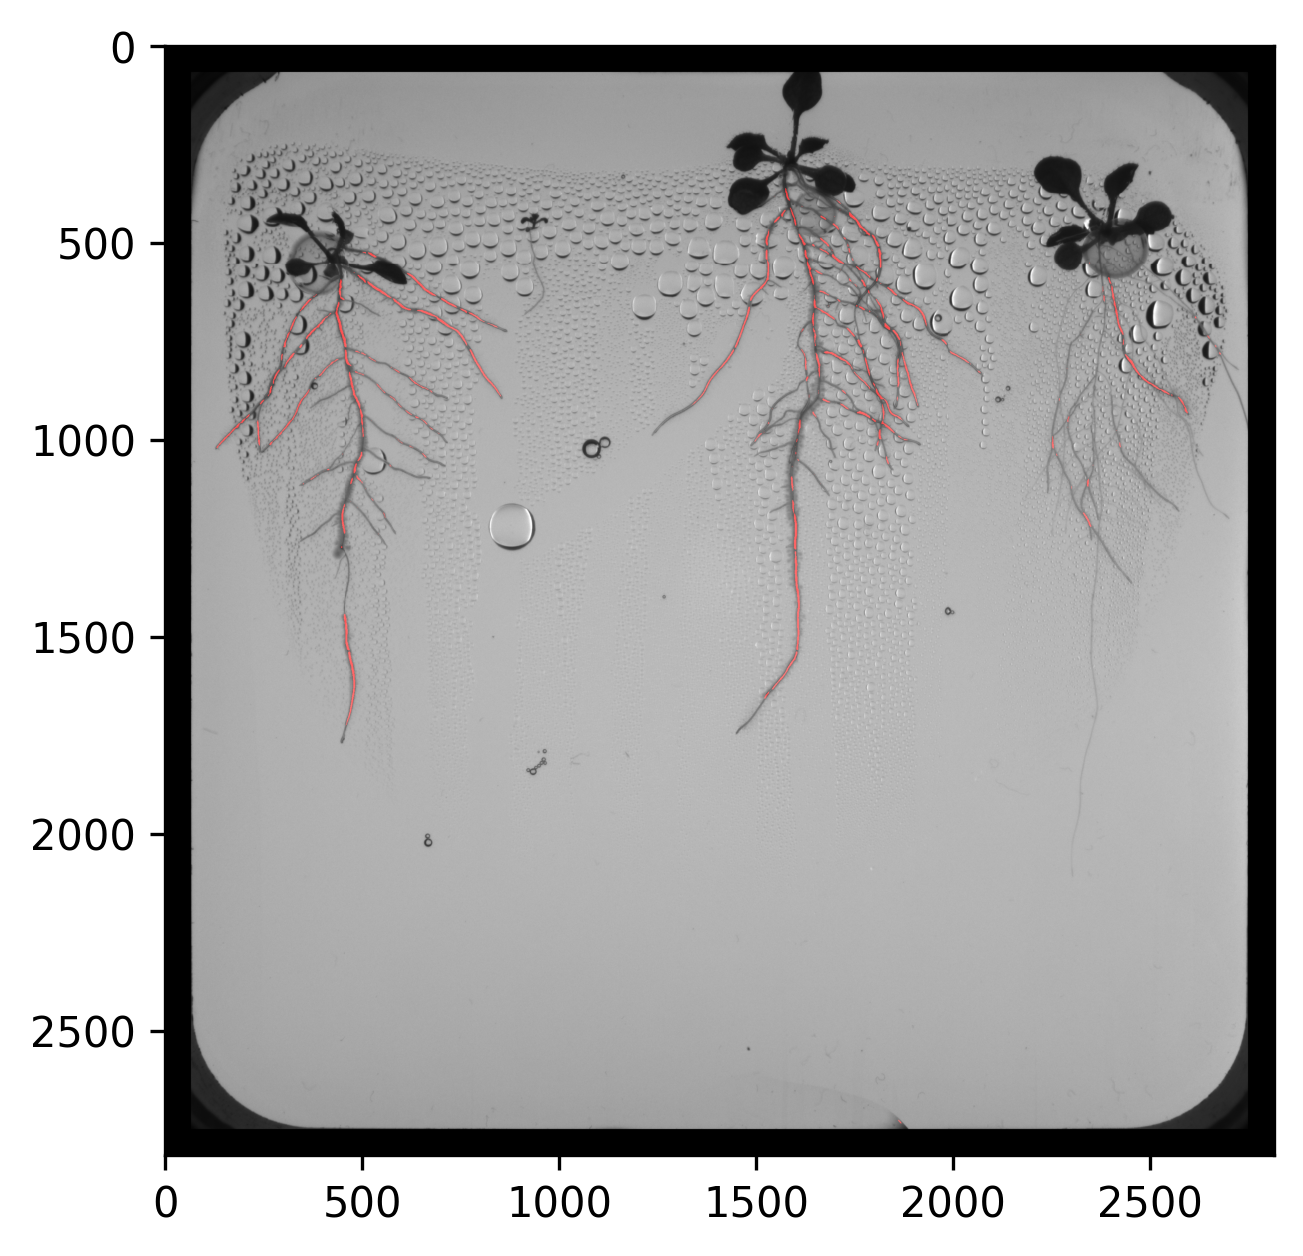

In [31]:
image_normalized = petri_dish_padded / 255.0

im_rgb = np.dstack([image_normalized, image_normalized, image_normalized])

mask_color = [1, 0, 0]

overlay = np.zeros_like(im_rgb, dtype=float)

overlay[predicted_mask == 255] = mask_color

im_overlay = im_rgb + overlay

im_overlay = np.clip(im_overlay, 0, 1)

plt.figure(dpi=300)
plt.imshow(im_overlay)


In [32]:
# Reverse Padding to Restore Original Shape
top, bottom, left, right = padding_info
predicted_mask_corrected = predicted_mask[top: -bottom or None, left: -right or None]

# Final Mask Aligns with Original Image
final_mask = np.zeros(original_shape, dtype=np.uint8)
x_offset = (original_shape[0] - predicted_mask_corrected.shape[0]) // 2
y_offset = (original_shape[1] - predicted_mask_corrected.shape[1]) // 2
final_mask[x_offset: x_offset + predicted_mask_corrected.shape[0], 
           y_offset: y_offset + predicted_mask_corrected.shape[1]] = predicted_mask_corrected

# Binary Mask
final_mask[final_mask >= 128] = 255
final_mask[final_mask < 128] = 0


In [37]:
final_mask.shape, image1.shape

((3006, 4112), (3006, 4112))

In [ ]:
output_filename = 'task5_test_image_prediction_Monika_Stangenberg_231648.png'
cv2.imwrite(output_filename, final_mask)